In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns; sns.set_style();
import pytorch_lightning as pl
from model.model_tf import ModelTF
from PIL import Image
import pandas as pd

# NOTE:
sample_thanh: data/VNOnDB/word/train_word/20140603_0003_BCCTC_tg_0_0_3.png

In [2]:
device = 'cpu'
# model = ModelTF.load_from_checkpoint('/home/aioz-intern-1/cnn_exp/tf_resnet34_2_lr1e-4/checkpoints/epoch=34.ckpt', map_location=device)
model = ModelTF.load_from_checkpoint('/home/python/Documents/Thesis/exp_weights/tf_exp/exp_tf_nlayers/tf_2en_2de_peimage/lightning_logs/version_0/checkpoints/epoch=44.ckpt', map_location=device)
# model = ModelTF.load_from_checkpoint('/home/python/Documents/Thesis/exp_weights/tf_exp/exp_tf_nlayers/tf_1en_1de/lightning_logs/version_0/checkpoints/epoch=46.ckpt', map_location=device)
# model = ModelTF.load_from_checkpoint('/home/python/Documents/Thesis/exp_weights/tf_exp/exp_tf_nlayers/tf_2en_2de/lightning_logs/version_0/checkpoints/epoch=45.ckpt', map_location=device)
model.eval();

In [3]:
image_transform = model.transform.test

In [4]:
path = 'data/VNOnDB/word/test_word/20160524_0166_9415_2_tg_0_2_16.png'
csv = 'data/VNOnDB/word/test_word_new.csv'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128 49


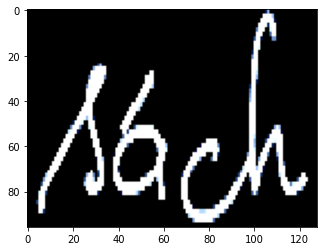

In [5]:
image = Image.open(path).convert('L')
width, height = image.size
print(width, height)
image = image_transform(image)
plt.imshow(image.permute(1,2,0))

In [6]:
df = pd.read_csv(csv, sep='\t', keep_default_na=False)
gt = df.loc[df['id']==path.split('/')[-1], 'label'].values[0]
print(f"Ground truth: {gt}")

Ground truth: cuốn


In [7]:
with torch.no_grad():
    outputs, lengths, (enc_weights, enc_dec_weights, dec_weights) = model.decode(image.unsqueeze(0), 15, 1, output_weights=True)
    for (output, length) in zip(outputs.cpu().tolist(), lengths.cpu().tolist()):
        output = list(map(model.vocab.int2char, output[:length]))
        output = model.vocab.process_label_invert(output)
        output = ' '.join(output)
        print(output)

s á c h <end>


In [8]:
enc_weights.size()

torch.Size([2, 1, 192, 192])

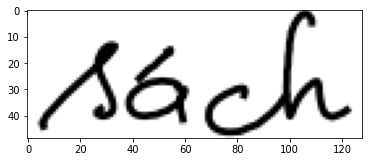

In [9]:
image = Image.open(path).convert('L').resize((width, height))
plt.imshow(image, cmap='gray')

In [10]:
a = torch.zeros(10)
a[5] = 1
a

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

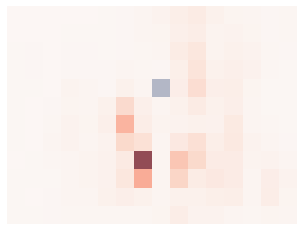

In [11]:
i = 100

root = torch.zeros(192)
root[i] = 1
root = root.reshape(16, 12)
root = root.transpose(-2, -1)

# first pixel
weight = enc_weights[0][0][i]
weight = weight.reshape(16, 12)
weight = weight.transpose(-2, -1)
# weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), (height, width), mode='bicubic', align_corners=True) # 1,H,W
# weight = weight.squeeze(0).squeeze(0) # H,W

# image = Image.open(path).convert('L').resize((width, height))
plt.axis('off')
fig = plt.imshow(root, cmap='Blues', alpha=1)
fig = plt.imshow(weight, cmap='Reds', alpha=0.7)
# fig = plt.imshow(image, cmap='gray', alpha=0.5)
plt.show()

In [12]:
def visualize_stn():
    if isinstance(model.stn, torch.nn.Identity):
        print('Model does not use STN')
        return
    stn = model.stn(inputs).detach()
    plt.figure(figsize=(20,15))
    stn = torchvision.utils.make_grid(stn, nrow=1)[0]
    plt.imshow(stn)
    plt.show()
visualize_stn()

Model does not use STN


In [13]:
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Segoe UI Symbol','simHei','Arial','sans-serif']

torch.Size([2, 1, 5, 5])
['<s>', 's', 'á', 'c', 'h']


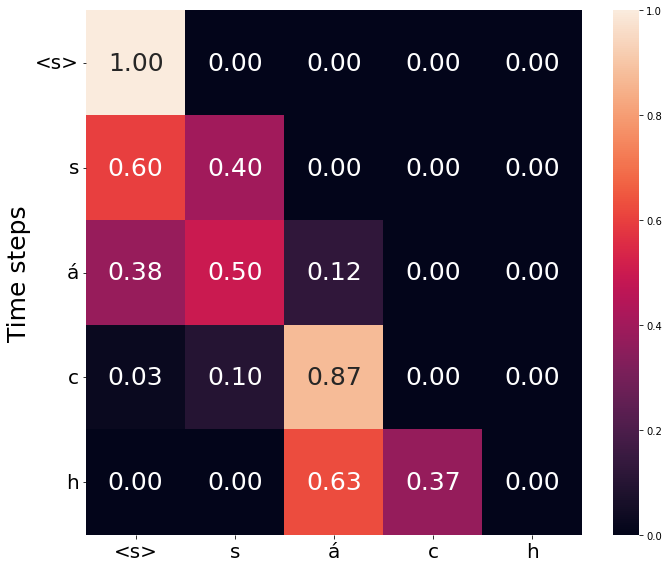

In [18]:
def visualize_dec_weights(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,T]
    L, B, T, T = weights.shape
    fig, axes = plt.subplots(B, 1, figsize=(10, 8), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, T]

    for i, sample in enumerate(weights):
        # sample: [T, T]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
#         output = [model.vocab.SOS] + output[:-1]
        output = ['<s>'] + output[:-1]
        print(output)
        sns.heatmap(sample, annot=True, fmt=".2f", annot_kws={"fontsize": 25}, ax=axes[i, 0])
        axes[i, 0].set_ylabel('Time steps', fontdict={'fontsize': 25})
        axes[i, 0].set_xticklabels(output, fontdict={'fontsize': 20})
        axes[i, 0].set_yticklabels(output, fontdict={'fontsize': 20, 'verticalalignment': 'center',
 'horizontalalignment': 'right'}, rotation='horizontal')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    fig.savefig(f"misc/attn-dec_{layer_idx}.png")
visualize_dec_weights(dec_weights[:, [0]]) # visualize first sample only

torch.Size([2, 1, 5, 5])
['<s>', 's', 'á', 'c', 'h']


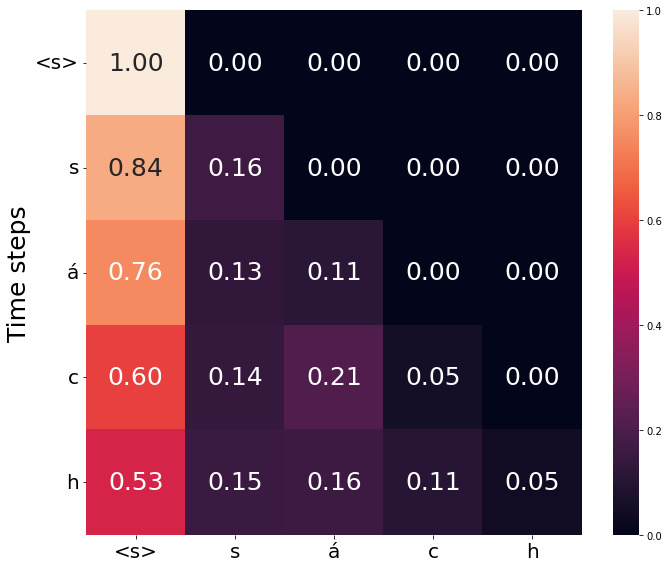

In [19]:
visualize_dec_weights(dec_weights[:, [0]], 0)

torch.Size([2, 1, 5, 12, 16])


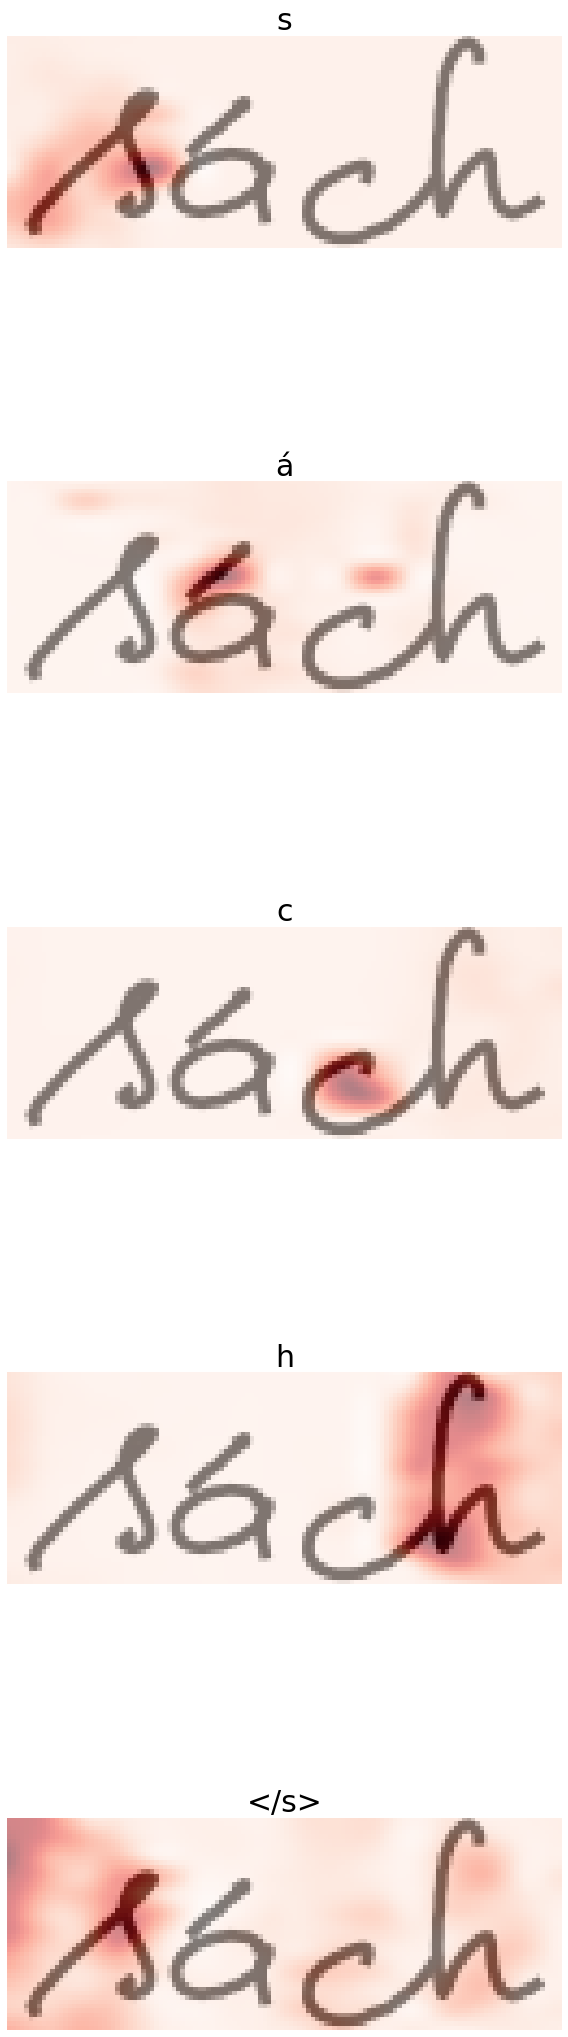

In [20]:
def visualize_enc_dec_weights(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,H,W]
    L, B, T, H, W = weights.shape
    alpha = 0.7
    fig, axes = plt.subplots(T, B, figsize=(8, 30), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, H, W]

    for i, sample in enumerate(weights):
        # sample: [T, H, W]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
        output = output[:-1] + ['</s>']
        for j, weight in enumerate(sample):
            # weight: [H, W]
            # weight = weight.transpose(-2, -1)
            weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), (height, width), mode='bicubic', align_corners=True) # 1,H,W
            weight = weight.squeeze(0).squeeze(0) # H,W
            
            image = Image.open(path).convert('L').resize((width, height))

            axes[j, i].set_title(output[j], fontdict={'fontsize': 30, 'fontweight': 'medium'})
            axes[j, i].axis('off')
            axes[j, i].imshow(weight, cmap='Reds', alpha=1)
            axes[j, i].imshow(image, cmap='gray', alpha=0.5)
            extent = axes[j, i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(f'misc/attn-enc-dec_{gt}_{j}.png', bbox_inches=extent.expanded(1, 1.1))
            
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.25)
    plt.show()
visualize_enc_dec_weights(enc_dec_weights[:, [0]]) # visualize first sample only

torch.Size([2, 1, 5, 12, 16])


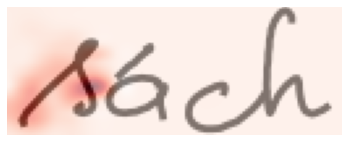

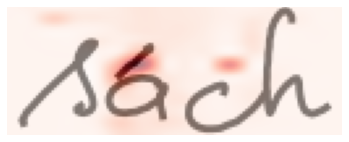

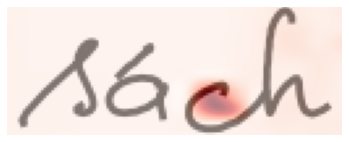

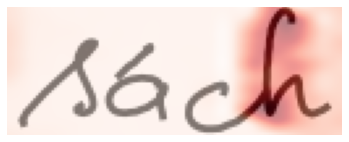

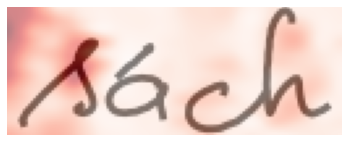

In [21]:
def visualize_enc_dec_weights_2(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,H,W]
    L, B, T, H, W = weights.shape
    alpha = 0.7
#     fig, axes = plt.subplots(T, B, figsize=(8, 30), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, H, W]

    for i, sample in enumerate(weights):
        # sample: [T, H, W]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
        for j, weight in enumerate(sample):
            # weight: [H, W]
            # weight = weight.transpose(-2, -1)
            weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), (height, width), mode='bicubic', align_corners=True) # 1,H,W
            weight = weight.squeeze(0).squeeze(0) # H,W
    
            image = Image.open(path).convert('L').resize((width, height))

#             extent = axes[j, i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            plt.axis('off')
            fig = plt.imshow(weight, cmap='Reds', alpha=1)
            fig = plt.imshow(image, cmap='gray', alpha=0.5)
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)
            plt.savefig(f'misc/attn-enc-dec_{gt}_{j}_1.png', bbox_inches='tight', pad_inches = 0)
            plt.show()
            
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.show()
visualize_enc_dec_weights_2(enc_dec_weights[:, [0]]) # visualize first sample only